## Classification

### MNIST

Fetch MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Dataset structure
- A DESCR key describing the dataset
- a data key containing an aray with one row per instance and one column per feature
- A target key containing an array with labels

In [3]:
X, y  = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Display image from dataset

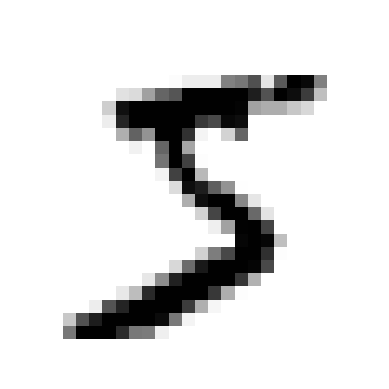

In [5]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np 

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

Print corresponding label

In [6]:
print(y[0])

5


Convert label from string to number

In [8]:
y = y.astype(np.uint8)

In [9]:
print(y)

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8


Create training set and test set

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

Create a binary classifier for number 5. The binary classifier only distinguishes between 5 and not-5. Create the target vectors for this task

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Create a *Stochastic Gradient Descent* classifier

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [15]:
sgd_clf.predict([some_digit])

I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

### Measuring Accuracy using Cross-Validation

#### Implementing Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

KeyError: "None of [Index([19964, 19965, 19966, 19967, 19968, 19969, 19970, 19971, 19972, 19974,\n       ...\n       59990, 59991, 59992, 59993, 59994, 59995, 59996, 59997, 59998, 59999],\n      dtype='int64', length=40000)] are in the [columns]"

Use cross_val_score() function to evaluate SGDClassifier model, using K-fold cross-validation with 3 folds

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [21]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

Using **confusion matrix** to evaluate the performance of a classifier. The idea is to count the number of times the classifier confused Class A with Class B

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


Plotting the confusion matrix

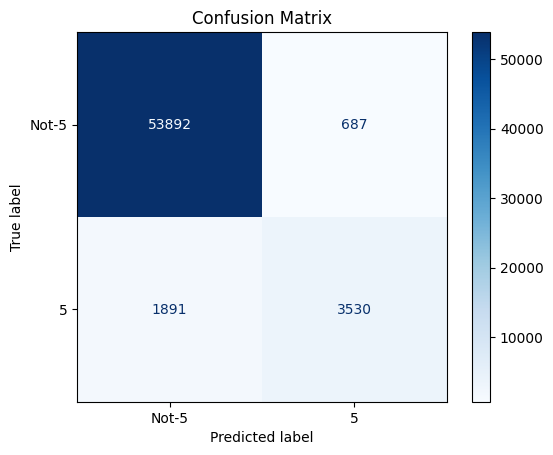

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not-5', '5'])
disp.plot(cmap=plt.cm.Blues) # Customize colormap if desired
plt.title("Confusion Matrix")
plt.show()

In [30]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

*Precision* and *recall* are key metrics for evaluating machine learning classification models, especially those with imbalanced data. *Precision* measures the accuracy of positive predictions, calculated as the ratio of true positives to all positive predictions (*true positives + false positives*). *Recall* measures the model's ability to find all positive instances, calculated as the ratio of true positives to all actual positive instances (*true positives + false negatives*)

In [32]:
from sklearn.metrics import precision_score, recall_score
print("Precision score ",precision_score(y_train_5, y_train_pred))
print("Recall score ",recall_score(y_train_5, y_train_pred))

Precision score  0.8370879772350012
Recall score  0.6511713705958311


Combine precision and recall into a single metric called F1 Score. F1 score calculates the harmonic mean between precision and recall scores

In [34]:
from sklearn.metrics import f1_score
print("F1 score ", f1_score(y_train_5, y_train_pred))

F1 score  0.7325171197343847


### Precision/Recall Trade-off

The SGDClassifier makes the prediction based on a threshold. Increasing the threshold too high will increase the precision (more true negative), whereas decreasing the threshold will increase the recall (more false negative)

Using *decision_function()* method to see the precision and recall scores

In [35]:
y_scores = sgd_clf.decision_function([some_digit]) #wrapping the first vector in a list [] to transform it into 2-D vector
y_scores

I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


SGDClassifier predicts the first number correctly with threshold = 0. Let's raise the threshold and try again

In [38]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


Note that raising the threshold caused the prediction to be incorrect. To choose a reasonable threshold, use cross_val_predict() function to get the scores of all instances in the training set, but instead of predictions, specify that the decision scores should be returned

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

using **precision_recall_curve()** to compute the precision and recall scores for all possible thresholds

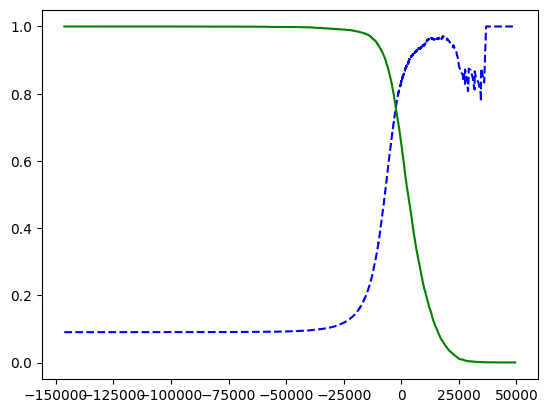

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [41]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [43]:
print(threshold_90_precision)

3370.0194991439557


In [44]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [46]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### The ROC curve

The *receiver operating characteristic* (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐
ting precision versus recall, the ROC curve plots the *true positive rate* (another name
for recall) against the *false positive rate* (FPR). The FPR is the ratio of negative instan‐
ces that are incorrectly classified as positive. It is equal to 1 – the *true negative* rate
(TNR), which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called *specificity*. Hence, the ROC curve plots *sensitivity* (recall) ver‐
sus 1 – *specificity*.

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plot FPR against TPR using matplotlib

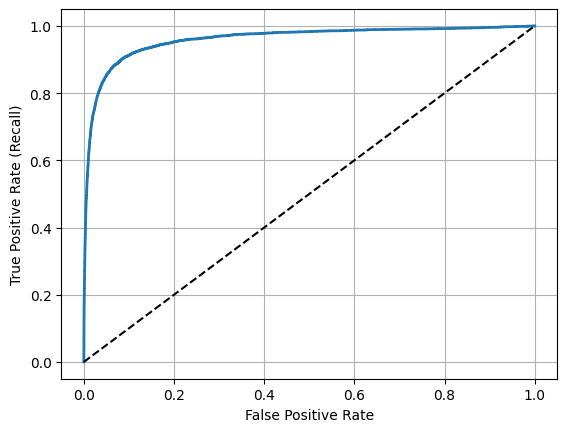

In [51]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #dashed diagonal
    #add axis labels and grid
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid(True)  # Set to True to display the grid
    
plot_roc_curve(fpr, tpr)
plt.show()

there is a trade-off: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [52]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

now train a RandomForestClassifier and compare its ROC curve and ROC
AUC score to those of the SGDClassifier. First, you need to get scores for each
instance in the training set

In [53]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [54]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Plot the ROC curve

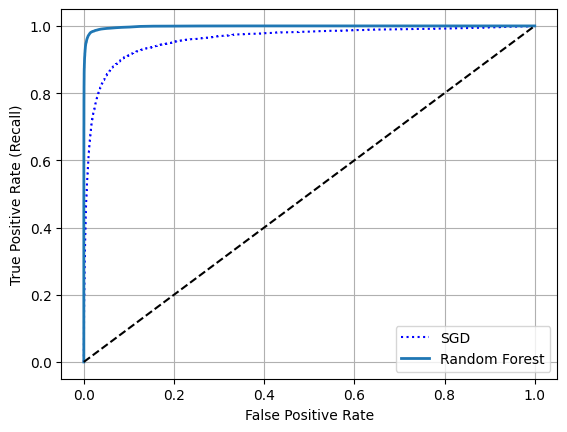

In [55]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest,  tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [62]:
print(precision_score(y_train_5, (y_scores >= threshold_90_precision)))
print(recall_score(y_train_5, (y_scores >= threshold_90_precision)))

0.9000345901072293
0.4799852425751706


### Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.

One way to create a system that can classify the digit images into 10 classes (from 0 to
9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-
detector, and so on). Then when you want to classify an image, you get the decision
score from each classifier for that image and you select the class whose classifier out‐
puts the highest score. This is called the one-versus-the-rest (OvR) strategy (also called
one-versus-all).

Another strategy is to train a binary classifier for every pair of digits: one to distin‐
guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advan‐
tage of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish

Try with Support Vector Machine Classifier

In [63]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

Scikit-learn used OvO strategy. It traine 45 binary classifiers, got the decision scores for the image and selected the highest score

Displaying all 10 scores per instance

In [64]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [65]:
np.argmax(some_digit_scores)

np.int64(5)

In [69]:
#When a classifier is trained, it stores the list of target classes in its
#classes_ attribute, ordered by value. In this case, the index of each
#class in the classes_ array conveniently matches the class itself
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [67]:
svm_clf.classes_[5]

np.uint8(5)

Using OneVsRestClassifier class to  train (can use OneVsOneClassifier to use OvO strategy)

In [70]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: U

array([5], dtype=uint8)

In [71]:
len(ovr_clf.estimators_)

10

Training with SGDClassifier

In [72]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [74]:
sgd_clf.decision_function([some_digit])

I:\AI\ML_Tensorflow\my_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

Evaluate the classifier using cross_val_score()

In [75]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Scaling the inputs

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

Plotting confusion matrix. First, make predictions using cross_val_predict(), then using confusion_matrix() to plot

In [78]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

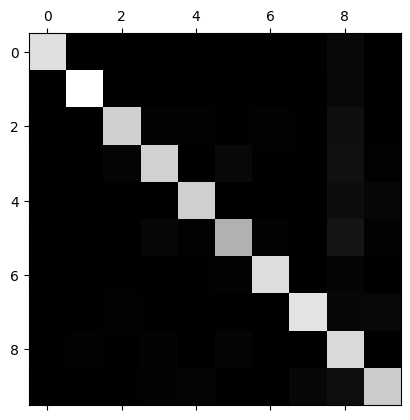

In [79]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Divide each value in the confusion matrix by the number of images in the corresponding class to compare the error rates instead of absolute numbers of erros

In [80]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

plot the confusion matrix again to show errors

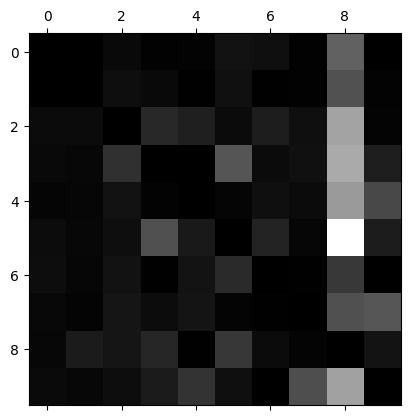

In [81]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Object ` filldiagonal()` not found.
